In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import cm
import json
from scipy.stats import kurtosis, skew, ks_2samp
from statsmodels.tsa.stattools import acf
import pyDOE
from smt.sampling_methods import LHS
import subprocess
from analytics.trqx.turquoise_exchange import get_trades, get_orders, get_market_data
from datetime import datetime
from pykalman import KalmanFilter
import scipy.interpolate as interpolate
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"

In [2]:
# Fix market order ratio to 0.1(then test when change mo_ratio of HF_MT changes to 0.01)
sbeta_mo_ratio = 0.01

In [147]:
model_params = {
  "ZI_base_params" : {
    "delta": 0.003,
    "lambda": 0.015,
    "limit_vol": 1,
    "market_vol": 1
  },
  "ZI_params" : {
    "alpha" : 0.2,
    "mu" : 0.02
  },
  "FT_params" : {
    "kappa_lo" : 0.15,
    "kappa_lo_3" : 0,
    "kappa_mo_ratio" : 0.1
  },
  "MT_params" : {
    "beta_lo" : 2.3,
    "beta_mo_ratio" : 0.1,
    "gamma" : 10,
    "alpha" : 0.001
  },
  "ST_params" : {
    "sbeta_lo" : 3.2,
    "sbeta_mo_ratio" : sbeta_mo_ratio,
    "sgamma" : 10,
    "salpha" : 0.99
  }
}
sim_params = {
  "reference_prc": 125.24,
  "closing_bid_prc": 128.22,
  "closing_ask_prc": 128.26,
  "tick_size": 0.02,
  "l2_depth": 10,
  "symbol": "ZIl",
  "tick_format": "LSE",
  "date": "2021-01-28",
  "date_format": "%d-%b-%Y %H:%M:%S",
  "n_runs": 3,
  "n_zi_traders": 50,
  "n_ft_traders": 50,
  "n_mt_traders": 50,
  "n_st_traders": 50,
  "n_mins": 510,
  "step_size": 100000,
  "n_threads": 6,
  "verbose": 2,
  "seed": 1234
}

In [148]:
# Functions for analysing historical and simulated stylised facts
def get_synthetic_market_data(data_path, tick_size=.02):
    df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format=turquoise_datetime_format)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    spread = l1S['prc'] - l1B['prc']
    spread = np.round(spread.fillna(method='ffill').fillna(method='bfill') / tick_size).dropna().astype(int)
    
    orders = pd.read_csv('{0}/orders.csv'.format(data_path)).set_index('time')
    orders.index = pd.to_datetime(orders.index, format=turquoise_datetime_format)
    
    b0 = l1B['prc'].shift(1)
    a0 = l1S['prc'].shift(1)
    depth_b = np.round((b0.reindex(orders.index) - orders['prc']) / tick_size)
    depth_a = np.round((orders['prc'] - a0.reindex(orders.index)) / tick_size)

    orders.loc[:,'depth'] = ((orders['side'] == 'B') * depth_b + (orders['side'] == 'S') * depth_a).values
    
    trades = pd.read_csv('{0}/trades.csv'.format(data_path)).set_index('time')
    trades.index = pd.to_datetime(trades.index, format=turquoise_datetime_format)
    md = {'l1B': l1B, 'l1S': l1S, 'mp': mp, 'spread': spread, 'orders': orders, 'trades': trades, 'a0': a0, 'b0': b0}
    return md

def get_synthetic_market_data_simplified(data_path, tick_size=.02):
    df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format=turquoise_datetime_format)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    
    orders = pd.read_csv('{0}/orders.csv'.format(data_path)).set_index('time')
    # orders.index = pd.to_datetime(orders.index, format=turquoise_datetime_format)
    
    md = {'mp': mp, 'orders': orders}
    return md

def get_fv_mv_value(data_path):
    fv = pd.read_csv('{0}/fundamental_value.csv'.format(data_path)).set_index('timestamp')
    fv.index = pd.to_datetime(fv.index, format=turquoise_datetime_format).floor('S')
    mv = pd.read_csv('{0}/momentum_value.csv'.format(data_path)).set_index('timestamp')
    mv.index = pd.to_datetime(mv.index, format=turquoise_datetime_format).floor('S')
    return fv.squeeze(), mv.squeeze()

# Distance Calculation
# Volatility
def sec_volatility_diff(ret1, ret2):
    return np.abs(ret1.std() - ret2.std())
# Autocorrelation diff
# For return first order acf, use small lags
def acf_diff(data1, data2, nlags):
    acf1 = acf(data1, nlags=nlags, fft=True)
    acf2 = acf(data2, nlags=nlags, fft=True)
    diff = acf1 - acf2
    return np.sum(np.abs(diff)) / (len(diff)-1)

def compute_distance(simulated, historical, ret1_lag=5, ret2_lag=20, bs_lag=10, mo_lag=10):
    ret_s, ret_h = simulated['ret'], historical['ret']
    vol_diff = sec_volatility_diff(ret_s, ret_h)
    cdf_ks = ks_2samp(ret_s, ret_h).statistic
    ret1_acf_diff = acf_diff(ret_s, ret_h, nlags=ret1_lag)
    ret2_acf_diff = acf_diff(ret_s**2, ret_h**2, nlags=ret2_lag)
    bs_series_s, bs_series_h = simulated['bs_series'], historical['bs_series']
    mo_series_s, mo_series_h = simulated['mo_series'], historical['mo_series']
    bs_acf_diff = acf_diff(bs_series_s, bs_series_h, nlags=bs_lag)
    mo_acf_diff = acf_diff(mo_series_s, mo_series_h, nlags=mo_lag)
    return cdf_ks, ret1_acf_diff, ret2_acf_diff, bs_acf_diff, mo_acf_diff
def get_historical(symbol, mic, datestr, tick_size, start, end):
    cloud_path = "D:/Simudyne Limited/Data - LSE Market Data"
    lit_path = '{0}/{1}'.format(cloud_path,  'L2/data-x.londonstockexchange.com/data-x/TRQX')
    lob_path = '{0}/{1}'.format(cloud_path,  'LOB')
    md = get_market_data(lit_path, lob_path, symbol, mic, pd.to_datetime(datestr), tick_size, include_l2=True)
    l1 = md['l1']
    h_depth = l1[l1['side'] == 'S'].depth + l1[l1['side'] == 'B'].depth
    b0 = l1[l1['side'] == 'B'].prc.round(2)
    a0 = l1[l1['side'] == 'S'].prc.round(2)
    raw_mid = ((a0 + b0) / 2.).dropna().loc[start:end]
    min_mid = raw_mid.resample('1min').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
    mid = raw_mid.resample('1S').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
    ret_h = (mid.values[1:] / mid.values[:-1] - 1) * 10000
    raw_ret_h = (raw_mid.values[1:] / raw_mid.values[:-1] - 1) * 10000
    market_orders = md['market_orders']
    mo_sign = market_orders['SIDE'].apply(lambda x: 1 if x=='Buy' else -1)
    h_orders = md['orders']
    real_orders = h_orders.dropna().copy()
    real_orders = real_orders[(real_orders['EXECTYPE']=='Insert') | (real_orders['EXECTYPE']=='Cancel')] # whether includr 'M'
    real_orders['tmp1'] = real_orders['SIDE'].apply(lambda x: 1 if x=='Buy' else -1)
    real_orders['tmp2'] = real_orders['EXECTYPE'].apply(lambda x: -1 if x=='Cancel' else 1)
    real_orders['pressure'] = real_orders['tmp1'] * real_orders['tmp2']
    real_p_series = real_orders['pressure']
    historical = {'ret': ret_h, 'bs_series': real_p_series, 'mo_series': mo_sign, 'raw_ret': raw_ret_h}
    tick_prc = ((a0 + b0) / 2.).dropna()
    return historical, tick_prc
def get_simulated(data_path, tick_size, start, end):
    md = get_synthetic_market_data_simplified(data_path, tick_size=tick_size)
    raw_mp, orders = md['mp'], md['orders']
    raw_mp = raw_mp.dropna().loc[start:end]
    # min_mp = raw_mp.resample('1min').last().fillna(method='ffill').dropna()
    mp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()#.last .reindex
    ret_s = (mp.values[1:] / mp.values[:-1] - 1) * 10000
    raw_ret_s = (raw_mp.values[1:] / raw_mp.values[:-1] - 1) * 10000
    # fv, mv = get_fv_mv_value(data_path)
    # distortion = mp - fv
    # Orders autocorrelation analysis
    orders_data = orders.copy()
    orders_data['tmp1'] = orders_data['side'].apply(lambda x: 1 if x=='B' else -1)
    orders_data['tmp2'] = orders_data['OrdType'].apply(lambda x: -1 if x=='C' else 1)
    orders_data['pressure'] = orders_data['tmp1'] * orders_data['tmp2']
    p_series = orders_data[(orders_data['pressure']!=0) & (orders_data['OrdType']!='M')]['pressure']
    # market order autocorrelation
    mo_series_s = orders_data[orders_data['OrdType'] == 'M']['pressure']
    simulated = {'ret': ret_s, 'bs_series': p_series, 'mo_series': mo_series_s, 'raw_ret': raw_ret_s}
    return simulated

In [149]:
# Get fundamental value from Kalman smoothing and interpolation
def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state
def get_interpolated_v(tick_prc, damping_factor=20):
    tick_mid = tick_prc.dropna()
    tmp = tick_mid.resample('1min').last().ffill().dropna()
    P = tmp.values
    Ve = Kalman1D(P, damping=damping_factor)[:,0]
    x = np.concatenate(([0], tick_mid.resample('1min').count().cumsum().values - 1))
    y = np.concatenate((Ve[:1], Ve))
    f = interpolate.interp1d(x, y, kind='cubic')
    newx = np.arange(0, len(tick_mid))
    inter_mid = f(newx)
    V_series = pd.Series(inter_mid, index=tick_mid.index)
    V_series = V_series.resample('100ms').last().ffill().bfill()
    return V_series, inter_mid
def plot_fundamental(inter_mid, tick_prc):
    fg, ax = plt.subplots(1,1,figsize=(10,2))
    pd.Series(inter_mid).plot(ax=ax, label='Interpolated from minute value', color='k')
    pd.Series(tick_prc.values).plot(ax=ax, label='tick mid price', style=':r')
    ax.legend(loc='best')
    ax.grid(True)
    ax.set_title('Market Prices-%s-interpolated from minute value'%(datestr))
    plt.show()

In [150]:
# Auxiliary functions
def update_model_params(model_params, params):
    model_params['FT_params']['kappa_lo'] = params['f_kappa']
    model_params['MT_params']['beta_lo'] = params['m_beta']
    model_params['ST_params']['sbeta_lo'] = params['s_beta'] if 's_beta' in params.keys() else 0
    # model_params['FT_params']['kappa_mo_ratio'] = params['f_mo_ratio']
    # model_params['MT_params']['beta_mo_ratio'] = params['m_mo_ratio']
    # model_params['ST_params']['sbeta_mo_ratio'] = params['s_mo_ratio'] if 's_mo_ratio' in params.keys() else 0
    return model_params
def update_sim_params(sim_params, prc, tick_size, datestr, n_runs=3):
    sim_params['closing_bid_prc'] = (prc // tick_size - 1) * tick_size
    sim_params['closing_ask_prc'] = (prc // tick_size + 1) * tick_size
    sim_params['tick_size'] = tick_size
    sim_params['date'] = datetime.strftime(pd.to_datetime(datestr), "%Y-%m-%d")
    sim_params['n_runs'] = n_runs
    return sim_params

def save_model_params(model_params, save_path):
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(model_params, f, ensure_ascii=False, indent=2)
        f.close()

def save_sim_params(sim_params, save_path):
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(sim_params, f, ensure_ascii=False, indent=2)
        f.close()

def run_simulation():
    cmd = "D:/projects/chiarella-abm/simulator/cmake-build-release/ZeroIntelligenceMarket.exe MultipleRun True"
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, cwd=r'D:/projects/chiarella-abm/simulator/cmake-build-release/')
    output = process.wait()
    return output

20210129


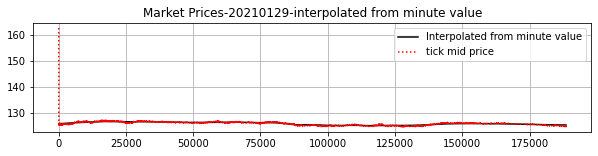

(100, 3)


In [151]:
symbol = 'VODl'
mic = 'XLON'
tick_size = .02
datestr = '20210129'

start = pd.to_datetime(datestr + ' 08:02:00')
end = pd.to_datetime(datestr + ' 16:29:00')
print(datestr)
historical, tick_prc = get_historical(symbol, mic, datestr, tick_size, start, end)
res_directory = 'MultipleRun/Results/'
# Get fundamental value
V_series, inter_mid = get_interpolated_v(tick_prc, damping_factor=20)
plot_fundamental(inter_mid, tick_prc)
V_series.to_csv('MultipleRun/source_fv.csv', index=False, header=False)
# Update sim_params
sim_params = update_sim_params(sim_params, V_series.values[0], tick_size, datestr, n_runs=3)
save_sim_params(sim_params, save_path='MultipleRun/sim_params.json')

sample_num = 100
f_kappa_list = [0.1, 5]
m_beta_list = [0.1, 5]
s_beta_list = [0.1, 5]
# f_mo_ratio_list = [0.1, 0.8]
# m_mo_ratio_list = [0.1, 0.8]
# s_mo_ratio_list = [0.001, 0.02]

xlimits = np.array([f_kappa_list, m_beta_list, s_beta_list])
x_sample = LHS(xlimits=xlimits, random_state=1234)(sample_num)
print(x_sample.shape)

In [152]:
res_df = pd.DataFrame(columns=['f_kappa', 'm_beta', 's_beta', 'cdf_ks_dist', 
                               'ret1_acf_diff', 'ret2_acf_diff', 'bs_acf_diff', 'mo_acf_diff', 'distance'])

In [121]:
for values in x_sample[3:4]:
    print(values)
    tmp = {}
    tmp['f_kappa'], tmp['m_beta'], tmp['s_beta'] = values
    model_params = update_model_params(model_params, tmp)
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    print('-----')
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    tmp_dist = []
    for n_ in names:
        data_path = res_directory + n_
        simulated = get_simulated(data_path, tick_size, start, end)
        dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=10, bs_lag=5, mo_lag=10)
        tmp_dist.append(dist)

    intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
    tmp['cdf_ks_dist'], tmp['ret1_acf_diff'], tmp['ret2_acf_diff'], tmp['bs_acf_diff'], tmp['mo_acf_diff'] = intermediate
    tmp['distance'] = intermediate.sum()
    print(tmp)
    res_df = res_df.append(tmp, ignore_index=True)
    
# res_df.to_csv('MultipleRun/res_df.csv', index=False)

[1.9865 4.7305 0.1735]
-----
{'f_kappa': 1.9865000000000004, 'm_beta': 4.7305, 's_beta': 0.1735, 'cdf_ks_dist': 0.06299083862905282, 'ret1_acf_diff': 0.024695275267647424, 'ret2_acf_diff': 0.03747234327773114, 'bs_acf_diff': 0.05766513016773519, 'mo_acf_diff': 0.08253153679057783, 'distance': 0.2653551241327444}


In [20]:
# Test pd.to_datetime speed.
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"
def custom_date_parser(x):
    return datetime.strptime(x, turquoise_datetime_format)
t1 = datetime.now()
df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
df_lob_l1.index = pd.to_datetime(df_lob_l1.index)
t2 = datetime.now()
df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format="%d-%b-%Y %H:%M:%S.%f")
t3 = datetime.now()
df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path),date_parser=custom_date_parser,parse_dates=['time']).set_index('time')
t4 = datetime.now()
print("Without format: ", t2 - t1)
print("Supply format: ", t3 - t2)
print("Parse date in read_csv: ", t4 - t3)


Without format:  0:00:17.629560
Supply format:  0:00:01.069307
Parse date in read_csv:  0:00:04.151423


# Bayesian Optimization

In [153]:
def func_opt(f_kappa, m_beta, s_beta):
    model_params = {
      "ZI_base_params" : {
        "delta": 0.003,
        "lambda": 0.015,
        "limit_vol": 1,
        "market_vol": 1
      },
      "ZI_params" : {
        "alpha" : 0.2,
        "mu" : 0.02
      },
      "FT_params" : {
        "kappa_lo" : 0.15,
        "kappa_lo_3" : 0,
        "kappa_mo_ratio" : 0.1
      },
      "MT_params" : {
        "beta_lo" : 2.3,
        "beta_mo_ratio" : 0.1,
        "gamma" : 10,
        "alpha" : 0.001
      },
      "ST_params" : {
        "sbeta_lo" : 3.2,
        "sbeta_mo_ratio" : sbeta_mo_ratio,
        "sgamma" : 10,
        "salpha" : 0.99
      }
    }
    tmp = {}
    tmp['f_kappa'], tmp['m_beta'], tmp['s_beta'] = f_kappa, m_beta, s_beta
    model_params = update_model_params(model_params, tmp)
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    tmp_dist = []
    for n_ in names:
        data_path = res_directory + n_
        simulated = get_simulated(data_path, tick_size, start, end)
        dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=10, bs_lag=5, mo_lag=10)
        tmp_dist.append(dist)

    intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
    return -1. * intermediate.sum()

def func_opt_mt1(f_kappa, m_beta):
    model_params = {
      "ZI_base_params" : {
        "delta": 0.003,
        "lambda": 0.015,
        "limit_vol": 1,
        "market_vol": 1
      },
      "ZI_params" : {
        "alpha" : 0.2,
        "mu" : 0.02
      },
      "FT_params" : {
        "kappa_lo" : 0.15,
        "kappa_lo_3" : 0,
        "kappa_mo_ratio" : 0.1
      },
      "MT_params" : {
        "beta_lo" : 2.3,
        "beta_mo_ratio" : 0.1,
        "gamma" : 10,
        "alpha" : 0.001
      },
      "ST_params" : {
        "sbeta_lo" : 3.2,
        "sbeta_mo_ratio" : sbeta_mo_ratio,
        "sgamma" : 10,
        "salpha" : 0.99
      }
    }
    tmp = {}
    tmp['f_kappa'], tmp['m_beta'] = f_kappa, m_beta
    model_params = update_model_params(model_params, tmp)
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    tmp_dist = []
    for n_ in names:
        data_path = res_directory + n_
        simulated = get_simulated(data_path, tick_size, start, end)
        dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=10, bs_lag=5, mo_lag=10)
        tmp_dist.append(dist)

    intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
    return -1. * intermediate.sum()

In [154]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space

pbs = {'f_kappa': tuple(f_kappa_list), 'm_beta': tuple(m_beta_list), 's_beta': tuple(s_beta_list)}
sim_params['n_st_traders'] = 50
save_sim_params(sim_params, save_path='MultipleRun/sim_params.json')
optimizer = BayesianOptimization(f=func_opt, pbounds=pbs, random_state=1)

# pbs_mt1 = {'f_kappa': tuple(f_kappa_list), 'm_beta': tuple(m_beta_list)}
# sim_params['n_st_traders'] = 0
# save_sim_params(sim_params, save_path='MultipleRun/sim_params.json')
# optimizer = BayesianOptimization(f=func_opt_mt1, pbounds=pbs_mt1, random_state=1)

In [155]:
# Later plot a graph about current max_value vs. iteration
optimizer.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  f_kappa  |  m_beta   |  s_beta   |
-------------------------------------------------------------
|  1        | -0.2559   |  2.143    |  3.63     |  0.1006   |
|  2        | -0.24     |  1.581    |  0.8191   |  0.5525   |
|  3        | -0.2018   |  1.013    |  1.793    |  2.044    |
|  4        | -0.1754   |  2.74     |  2.154    |  3.458    |
|  5        | -0.2564   |  1.102    |  4.403    |  0.2342   |
|  6        | -0.1865   |  3.385    |  2.145    |  2.838    |
|  7        | -0.1769   |  0.7879   |  1.071    |  4.024    |
|  8        | -0.1748   |  4.844    |  1.636    |  3.492    |
|  9        | -0.2363   |  4.394    |  4.484    |  0.5167   |
|  10       | -0.1686   |  0.2914   |  0.9322   |  4.403    |
|  11       | -0.1749   |  0.5819   |  2.163    |  4.794    |
|  12       | -0.213    |  2.713    |  3.49     |  1.646    |
|  13       | -0.2551   |  3.464    |  4.19     |  0.1896   |
|  14       | -0.1743   |  3.776    |  4.945    |  3.766    |
|  15   

In [156]:
print(optimizer.max)
# for i, res in enumerate(optimizer.res):
#     print("Iteration {}: \n\t{}".format(i, res))

{'target': -0.1600992419111944, 'params': {'f_kappa': 3.077973302267514, 'm_beta': 0.1, 's_beta': 5.0}}


In [157]:
ret_h = historical['ret']
raw_ret_h = historical['raw_ret']
bs_h = historical['bs_series'].values
mo_h = historical['mo_series'].values


model_params = update_model_params(model_params, optimizer.max['params'])
# model_params['ST_params']['sbeta_mo_ratio'] = 0.001
save_model_params(model_params, save_path='MultipleRun/model_params.json')
flag = run_simulation()
assert flag == 0, "Error when running simulation!"

print('-----')
names = [x for x in os.listdir(res_directory) if 'run_' in x]
tmp_dist = []
div_dict = {'ret': [], 'raw_ret': [], 'bs': [], 'mo': []}
for n_ in names:
    print(n_)
    data_path = res_directory + n_
    simulated = get_simulated(data_path, tick_size, start, end)
    ret_s = simulated['ret']
    raw_ret_s = simulated['raw_ret']
    bs_s = simulated['bs_series'].values
    mo_s = simulated['mo_series'].values
    print('ret')
    div_dict['ret'].append(ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    print('raw_ret')
    div_dict['raw_ret'].append(ret_gsl_div(raw_ret_h, raw_ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
    print('bs')
    div_dict['bs'].append(ret_gsl_div(bs_h, bs_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
    print('mo')
    div_dict['mo'].append(ret_gsl_div(mo_h, mo_s, b=2, L=10, min_per=0, max_per=100, unit=1000))

    dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=10, bs_lag=5, mo_lag=10)
    tmp_dist.append(dist)

intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
tmp['cdf_ks_dist'], tmp['ret1_acf_diff'], tmp['ret2_acf_diff'], tmp['bs_acf_diff'], tmp['mo_acf_diff'] = intermediate
tmp['distance'] = intermediate.sum()
print('distance: %.6f'%(tmp['distance']))
for key in div_dict.keys():
    print('GSL-div in %7s: mean: %.6f, std: %.8f'%(key, np.mean(div_dict[key]), np.std(div_dict[key])))
print('-----------------------------')


-----
run_00000
ret
raw_ret
bs
mo
run_00001
ret
raw_ret
bs
mo
run_00002
ret
raw_ret
bs
mo
distance: 0.160099
GSL-div in     ret: mean: 0.452946, std: 0.00150665
GSL-div in raw_ret: mean: 0.581352, std: 0.00117537
GSL-div in      bs: mean: 1.006315, std: 0.00018260
GSL-div in      mo: mean: 0.993583, std: 0.00666996
-----------------------------


In [91]:
gp = optimizer._gp
print(optimizer.max)

{'target': -0.2739173748888215, 'params': {'f_kappa': 3.719447567617542, 'm_beta': 1.560880283525908}}


0 ('f_kappa', (0.1, 5))
1 ('m_beta', (0.1, 5))
2 ('s_beta', (0.1, 5))


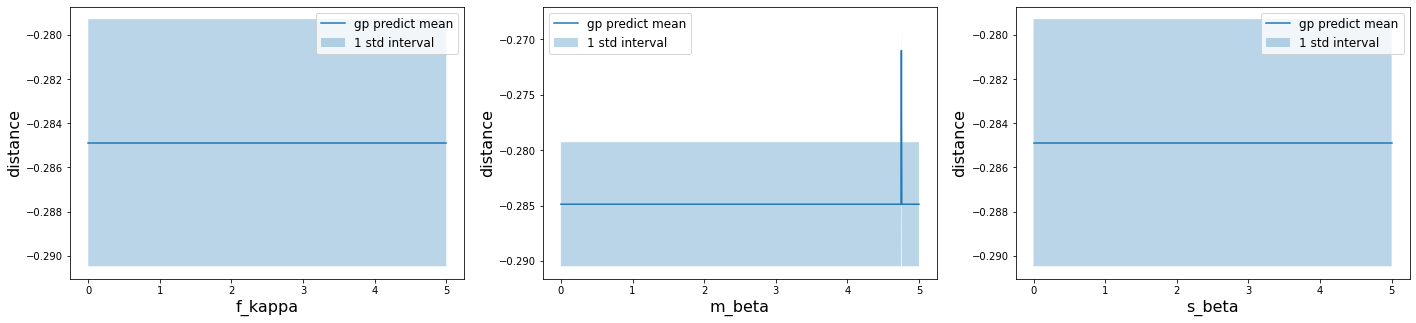

In [85]:
# Plot the 1d-slice(2d contour) of the objective function
num = 1000
opt = np.fromiter(optimizer.max['params'].values(), dtype=float)
opt_arr = np.array([opt for _ in range(num)])

col = 3
fig, axs = plt.subplots(1,col,figsize=(24,5))
for i, item in enumerate(pbs.items()):
# for i, item in enumerate(pbs_mt1.items()):
    name = item[0]
    lb, ub = item[1][0], item[1][1]
    print(i, item)
    x = opt_arr.copy()
    x[:, i] = np.linspace(0.0, ub, num)
    y, sigma = gp.predict(x, return_std=True)
    y1, y2 = y - 1.00 * sigma, y + 1.00 * sigma
    axs[i].plot(x[:, i], y, label='gp predict mean')
    axs[i].fill_between(x[:, i], y1, y2, alpha=0.3, label='1 std interval')
    axs[i].set_xlabel(name, size=16)
    axs[i].set_ylabel('distance', size=16)
    axs[i].legend(loc='best', prop={'size': 12})

## Bayesian Optimization Results

## VODl; 2021-01-28
### 2MT(s_mo_ratio = 0.1):
{'target': -0.268804, 'params': {'f_kappa': 4.7027, 'm_beta': 4.75479, 's_beta': 1.4677}} <br>
distance:  0.268804<br>
GSL-div in     ret: mean: 0.476750, std: 0.00078676<br>
GSL-div in raw_ret: mean: 0.482725, std: 0.00040592<br>
GSL-div in      bs: mean: 1.005129, std: 0.00041858<br>
GSL-div in      mo: mean: 0.995331, std: 0.00371474<br>

### 2MT(s_mo_ratio = 0.01):
distance: 0.258119<br>
GSL-div in     ret: mean: 0.477789, std: 0.00058116<br>
GSL-div in raw_ret: mean: 0.487098, std: 0.00027285<br>
GSL-div in      bs: mean: 1.005018, std: 0.00031047<br>
GSL-div in      mo: mean: 0.969691, std: 0.00081486<br>

### 1 MT:
{'target': -0.273917, 'params': {'f_kappa': 3.7194476, 'm_beta': 1.560880}}<br>
distance: 0.273917<br>
GSL-div in     ret: mean: 0.477955, std: 0.00045283<br>
GSL-div in raw_ret: mean: 0.485296, std: 0.00008023<br>
GSL-div in      bs: mean: 1.005844, std: 0.00014659<br>
GSL-div in      mo: mean: 0.973472, std: 0.00321610<br>

## VODl; 2021-01-29
### 2MT(s_mo_ratio = 0.1):
{'target': -0.185383, 'params': {'f_kappa': 0.78626, 'm_beta': 3.06834, 's_beta': 5.0}} <br>
distance: 0.185383<br>
GSL-div in     ret: mean: 0.452539, std: 0.00090359<br>
GSL-div in raw_ret: mean: 0.585579, std: 0.00067957<br>
GSL-div in      bs: mean: 1.005775, std: 0.00014685<br>
GSL-div in      mo: mean: 1.041311, std: 0.00454099<br>
### 2MT(s_mo_ratio = 0.01):
{'target': -0.160099, 'params': {'f_kappa': 3.07797, 'm_beta': 0.1, 's_beta': 5.0}}<br>
distance: 0.160099<br>
GSL-div in     ret: mean: 0.452946, std: 0.00150665<br>
GSL-div in raw_ret: mean: 0.581352, std: 0.00117537<br>
GSL-div in      bs: mean: 1.006315, std: 0.00018260<br>
GSL-div in      mo: mean: 0.993583, std: 0.00666996<br>
### 1 MT:
{'target': -0.247554, 'params': {'f_kappa': 4.7654336, 'm_beta': 2.779895}}<br>
distance: 0.247554<br>
GSL-div in     ret: mean: 0.453974, std: 0.00051712<br>
GSL-div in raw_ret: mean: 0.568835, std: 0.00042564<br>
GSL-div in      bs: mean: 1.011131, std: 0.00068976<br>
GSL-div in      mo: mean: 1.000403, std: 0.00769910<br>

## GSL-div analysis

In [82]:
import scipy.stats as sc
from functools import reduce

def get_symbolised_ts(ts, b, L, min_per=1, max_per=99, state_space=None):
    # if no state space is defined we generate our own based on
    # either the standard percentiles or those given by the user
    cuts = []
    if not state_space:
        for x in ts:
            min_p = np.percentile(x, min_per)
            max_p = np.percentile(x, max_per)
            cuts.append(np.linspace(min_p, max_p, b+1))
    else:
        cuts = np.linspace(state_space[0], state_space[1], b+1)
    # now we map the time series to the bins in the symbol space
    symbolised_ts = np.array([np.clip(np.digitize(t, cut, right=True), 1, b) for t, cut in zip(ts,cuts)])
    # to be able to deal with "words" or combination of symbols it is easier
    # to deal with them as strings in pandas dfs
    # TODO: Maybe better way of doing this
    sym_str = pd.DataFrame(symbolised_ts).astype(str)
    # collect all symbol dataframes based on block size given
    all_dfs = []
    all_dfs.append(sym_str)
    tmp = sym_str.values
    for l in range(1, L):
        tmp = tmp[:, :-1] + sym_str.values[:, l:]
        all_dfs.append(pd.DataFrame(tmp))
    return all_dfs


def get_weights(weight_type, L):
    if weight_type == 'uniform':
        w = np.array([1. / L] * L)
    elif weight_type == 'add-progressive':
        w = np.array([2. / (L * (L + 1))]*L).cumsum()
    return w


def gsl_div(original, model, weights='add-progressive', b=5, L=6, min_per=1, max_per=99, state_space=None):
    all_ts = np.concatenate([original, model])
    # determine the time series length
    T = original.shape[1]
    if T < L:
        raise ValueError('Word length cant be longer than timeseries')
    # symbolise time-series
    sym_ts = get_symbolised_ts(all_ts, b=b, L=L, min_per=min_per,
                               max_per=max_per, state_space=state_space)
    raw_divergence = []
    correction = []
    # run over all word sizes
    for n, ts in enumerate(sym_ts):
        # get frequency distributions for original and replicates
        # could do it by applying a pd.value_counts to every column but this
        # way you get a 10x speed up
        fs = pd.DataFrame((ts.stack().reset_index()
                           .groupby([0, "level_0"]).count() /
                           len(ts.T)).unstack().values.astype(float))

        # replace NaN with 0 so that log does not complain later
        fs = fs.replace(np.nan, 0)
        # determine the size of vocabulary for the right base in the log
        base = b**(n+1)
        # calculate the distances between the different time-series
        # give a particluar word size
        M = (fs.iloc[:, 1:].values +
             np.expand_dims(fs.iloc[:, 0].values, 1)) / 2.
        temp = (2 * sc.entropy(M, base=base) -
                sc.entropy(fs.values[:, 1:], base=base))
        raw_divergence.append(reduce(np.add, temp) /
                              float((len(fs.columns) - 1)))
        cardinality_of_m = fs.apply(lambda x: reduce(np.logical_or, x),
                                    axis=1).sum()
        # if there is only one replicate this has to be handled differently
        if len(fs.columns) == 2:
            cardinality_of_reps = fs.iloc[:, 1].apply(lambda x: x != 0).sum()
        else:
            cardinality_of_reps = fs.iloc[:, 1:].apply(
                lambda x: reduce(np.logical_or, x), axis=1).sum()
        # calculate correction based on formula 9 line 2 in paper
        correction.append(2*((cardinality_of_m - 1) / (4. * T)) -
                          ((cardinality_of_reps - 1) / (2. * T)))

    w = get_weights(weight_type=weights, L=L)
    weighted_res = (w * np.array(raw_divergence)).sum(axis=0)
    weighted_correction = (w * np.array(correction)).sum()

    return weighted_res + weighted_correction
def ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000):
    length = min(len(ret_h), len(ret_s))
    res_list = []
    for i in range(length//unit):
        h_ts = ret_h[(i*unit):((i+1)*unit)].reshape(1,-1)
        s_ts = ret_s[(i*unit):((i+1)*unit)].reshape(1,-1)
        res_list.append(gsl_div(h_ts, s_ts, 'add-progressive',b=b, L=L, min_per=min_per, max_per=max_per))
    # print(res_list)
    return np.mean(res_list)

In [76]:
ret_h = historical['ret']
raw_ret_h = historical['raw_ret']
bs_h = historical['bs_series'].values
mo_h = historical['mo_series'].values

p_list = [[2., 3., 3.]]

In [77]:
for values in p_list:
    print(values)
    tmp = {}
    tmp['f_kappa'], tmp['m_beta'], tmp['s_beta'] = values
    model_params = update_model_params(model_params, tmp)
    save_model_params(model_params, save_path='MultipleRun/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    print('-----')
    names = [x for x in os.listdir(res_directory) if 'run_' in x]
    tmp_dist = []
    div_dict = {'ret': [], 'raw_ret': [], 'bs': [], 'mo': []}
    for n_ in names:
        data_path = res_directory + n_
        simulated = get_simulated(data_path, tick_size, start, end)
        ret_s = simulated['ret']
        raw_ret_s = simulated['raw_ret']
        bs_s = simulated['bs_series'].values
        mo_s = simulated['mo_series'].values
        
        div_dict['ret'].append(ret_gsl_div(ret_h, ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
        div_dict['raw_ret'].append(ret_gsl_div(raw_ret_h, raw_ret_s, b=5, L=10, min_per=1, max_per=99, unit=1000))
        div_dict['bs'].append(ret_gsl_div(bs_h, bs_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
        div_dict['mo'].append(ret_gsl_div(mo_h, mo_s, b=2, L=10, min_per=0, max_per=100, unit=1000))
        
        dist = compute_distance(simulated, historical, ret1_lag=5, ret2_lag=10, bs_lag=5, mo_lag=10)
        tmp_dist.append(dist)

    intermediate = np.array(tmp_dist).mean(axis=0) + np.array(tmp_dist).std(axis=0)
    tmp['cdf_ks_dist'], tmp['ret1_acf_diff'], tmp['ret2_acf_diff'], tmp['bs_acf_diff'], tmp['mo_acf_diff'] = intermediate
    tmp['distance'] = intermediate.sum()
    print('distance: ', tmp['distance'])
    for key in div_dict.keys():
        print('GSL-div in %7s: mean: %.6f, std: %.8f'%(key, np.mean(div_dict[key]), np.std(div_dict[key])))
    print('-----------------------------')

[0.1, 0.1, 3.0, 0.1, 3.0, 0.01]
-----
distance:  0.791886093148175
GSL-div in     ret: mean: 0.503454, std: 0.00605245
GSL-div in raw_ret: mean: 0.549056, std: 0.00026632
GSL-div in      bs: mean: 1.003644, std: 0.00090373
GSL-div in      mo: mean: 1.009333, std: 0.00360170
-----------------------------


In [113]:
# pd.Series(ret_s).to_pickle('ret_h.pkl')